<a href="https://colab.research.google.com/github/rrenatovich/deep_learning/blob/main/Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек и функций

In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, classification_report

In [4]:
def plot_training_curves(history):

  tr_acc = history.history['accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  epochs = [i+1 for i in range(len(tr_acc))] # количество эпох обучения
  loss_label = f'best epoch = {str(index_loss + 1)}'
  acc_label = f'best epoch = {str(index_acc + 1)}'

  # Plot training history
  plt.figure(figsize= (12, 5))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(epochs, tr_loss, 'r', label='Ошибка обучения')
  plt.plot(epochs, val_loss, 'g', label='Ошибка валидации')
  plt.scatter(index_loss + 1, val_lowest, s=150, c= 'blue', label=loss_label)
  plt.title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение ошибки', fontsize=12)
  plt.legend(fontsize=12)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, tr_acc, 'r', label='Точность обучения')
  plt.plot(epochs, val_acc, 'g', label='Точность валидации')
  plt.scatter(index_acc + 1 , acc_highest, s=150, c= 'blue', label=acc_label)
  plt.title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение точности', fontsize=12)
  plt.legend(fontsize=12)

  plt.tight_layout
  plt.show()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='PuBu', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

def generate_preformance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted", zero_division=0)
  model_roc_auc = roc_auc_score(y_true, y_probabilities, multi_class="ovr")

  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'F1_score:\t\t{model_f1:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')

  return

def plot_multiclass_roc(y_test, y_prob, n_classes, figsize=(5,5)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title("График ROC-кривой", fontsize=14, fontweight="bold")
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='AUC = %0.3f for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()

# Чтение данных

In [5]:
df = pd.read_csv("/content/poem_ds.csv", sep=";")
df.head()

,author,fragment
0,Цветаева,"Мне нравится, что Вы больны не мной,\nМне нрав..."
1,Цветаева,"Спасибо Вам и сердцем и рукой\nЗа то, что Вы м..."
2,Цветаева,Почему ты плачешь? — Так. —\nПлакать так смешн...
3,Цветаева,"Пышность замков, разгульность охоты,\nИспытань..."
4,Цветаева,"Вот: слышится — а слов не слышу,\nВот: близитс..."


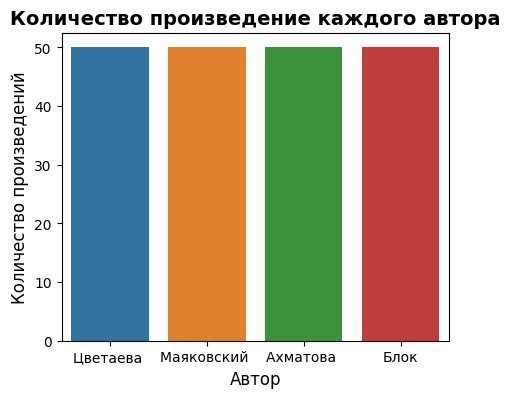

In [6]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='author')

plt.xlabel('Автор', fontsize=12)
plt.ylabel('Количество произведений', fontsize=12)
plt.title('Количество произведение каждого автора', fontsize=14, fontweight="bold");

# Предобработка данных




Удалим из текста перенос строки, пунктуацию, и приведем все буквы к нижнему регистру

In [7]:
def unify_fragment(elem):
  elem = re.sub(r'[^\w\s]', ' ', elem)
  elem = re.sub(r'\n', ' ', elem)
  elem = elem.lower()
  elem = ' '.join(elem.split())

  return elem

In [8]:
df["fragment"] = df["fragment"].apply(unify_fragment)

In [9]:
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["author"])

In [10]:
df.head()

,author,fragment,label
0,Цветаева,мне нравится что вы больны не мной мне нравитс...,3
1,Цветаева,спасибо вам и сердцем и рукой за то что вы мен...,3
2,Цветаева,почему ты плачешь так плакать так смешно и глу...,3
3,Цветаева,пышность замков разгульность охоты испытанья т...,3
4,Цветаева,вот слышится а слов не слышу вот близится и ть...,3


# Получим токенизатор

In [11]:
def get_max_word_count(data):
  max = 0
  for elem in data:
    if (len(elem.split()) > max):
      max = len(elem.split())

  return max

In [12]:
max_length = get_max_word_count(df["fragment"])
max_length

124

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
sentences = df["fragment"]

In [15]:
input_ids = []
attention_masks = []
max_length = get_max_word_count(df["fragment"])

if (max_length > 512):
  max_length = 124

for sent in sentences:
  bert_inp = tokenizer.encode_plus(sent,
                                   add_special_tokens=True,
                                   max_length=124,
                                   pad_to_max_length=True,
                                   truncation=True,
                                   return_attention_mask=True)

  input_ids.append(bert_inp['input_ids'])
  attention_masks.append(bert_inp['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
target = np.array(pd.get_dummies(df['label']))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Деление на выборки

In [17]:
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(input_ids, target, attention_masks, test_size=0.1, random_state = 47)
X_train, X_val, y_train, y_val, train_mask, val_mask = train_test_split(X_train, y_train, train_mask, test_size=0.1, random_state = 47)

In [18]:
y_tested = np.argmax(y_test, axis=1)

In [19]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (162, 124)
Размер валидационной выборки: (18, 124)
Размер тестовой выборки: (20, 124)


# Создание модели

## Bert fine tuning

In [18]:
def create_model(model):
    input_ids = keras.Input(shape=(max_length,), dtype='int32')
    attention_masks = keras.Input(shape=(max_length,), dtype='int32')

    output = model(input_ids, attention_masks)
    encoder_output = output[0]
    pooler_output = output[1]
    output = keras.layers.Concatenate()([encoder_output[:,0,:], pooler_output])

    output = keras.layers.Dense(128, activation='relu')(output)
    output = keras.layers.Dense(64, activation='relu')(output)
    output = keras.layers.Dense(32, activation='relu')(output)
    output = keras.layers.Dense(df['author'].nunique(), activation='softmax')(output)
    model = keras.models.Model(inputs=[input_ids, attention_masks],
                                  outputs=output)


    for layer in model.layers[:3]:
        layer.trainable = False
    return model

In [19]:
model = create_model(bert_model)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 124, 7                                           
                             68),                                                             

In [20]:
history = model.fit([X_train, train_mask],
                    y_train,
                    batch_size=32,
                    epochs=6,
                    validation_data=([X_val, val_mask], y_val))

Epoch 1/6
6/6 [==============================] - 27s 873ms/step - loss: 1.4312 - accuracy: 0.2593 - val_loss: 1.3813 - val_accuracy: 0.3333
Epoch 2/6
6/6 [==============================] - 2s 255ms/step - loss: 1.4646 - accuracy: 0.2284 - val_loss: 1.4296 - val_accuracy: 0.2778
Epoch 3/6
6/6 [==============================] - 2s 254ms/step - loss: 1.4356 - accuracy: 0.2469 - val_loss: 1.3856 - val_accuracy: 0.3333
Epoch 4/6
6/6 [==============================] - 2s 288ms/step - loss: 1.4119 - accuracy: 0.2099 - val_loss: 1.3916 - val_accuracy: 0.3333
Epoch 5/6
6/6 [==============================] - 2s 258ms/step - loss: 1.3831 - accuracy: 0.2593 - val_loss: 1.4449 - val_accuracy: 0.2222
Epoch 6/6
6/6 [==============================] - 2s 274ms/step - loss: 1.4169 - accuracy: 0.2716 - val_loss: 1.3856 - val_accuracy: 0.3333


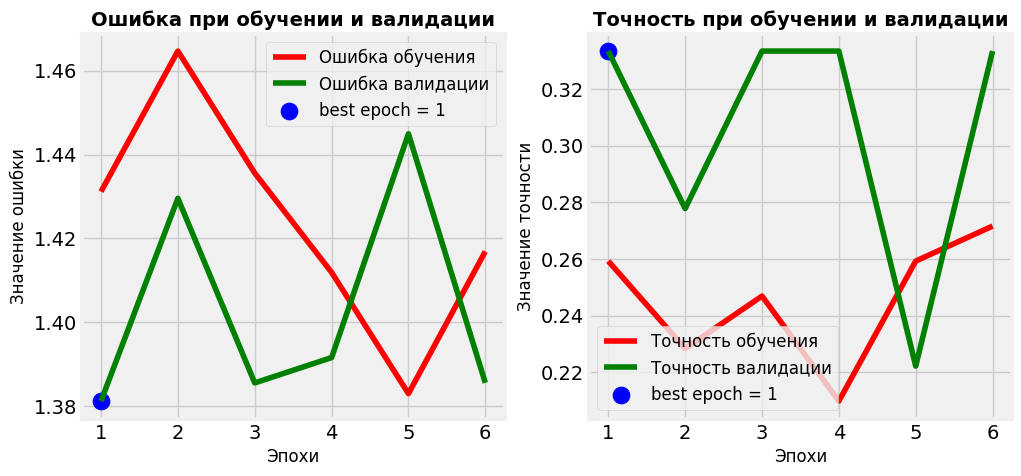

In [21]:
plot_training_curves(history)

In [22]:
y_predicted_prob = model.predict([X_test, test_mask])
y_predicted = np.argmax(y_predicted_prob, axis=1)

1/1 [==============================] - 6s 6s/step


In [24]:
generate_preformance_scores(y_tested, y_predicted, y_predicted_prob)

Accuracy Score:		0.2143
Precision_score:	0.1615
Recall_score:		0.3000
F1_score:		0.2100
AUC Score:		0.6127


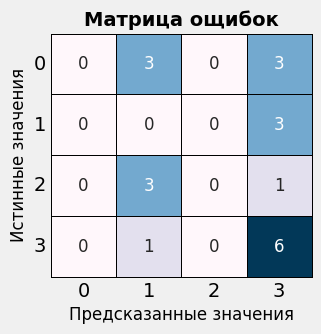

In [25]:
plot_confusion_matrix(y_tested, y_predicted, figsize=(3, 3))

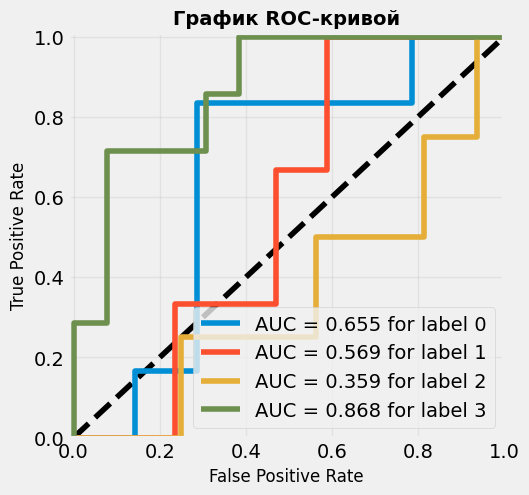

In [26]:
plot_multiclass_roc(y_tested, y_predicted_prob, 4)

## Bert transfer learning

In [20]:
def create_model(model):
    input_ids = keras.Input(shape=(max_length,), dtype='int32')
    attention_masks = keras.Input(shape=(max_length,), dtype='int32')

    output = model(input_ids, attention_masks)
    encoder_output = output[0]
    pooler_output = output[1]
    output = keras.layers.Concatenate()([encoder_output[:,0,:], pooler_output])

    output = keras.layers.Dense(64, activation='relu')(output)
    output = keras.layers.Dense(32, activation='relu')(output)
    output = keras.layers.Dense(df['author'].nunique(), activation='softmax')(output)
    model = keras.models.Model(inputs=[input_ids, attention_masks],
                                  outputs=output)

    return model

In [21]:
model = create_model(bert_model)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 124, 7                                           
                             68),                                                             

In [22]:
history = model.fit([X_train, train_mask],
                    y_train,
                    batch_size=32,
                    epochs=6,
                    validation_data=([X_val, val_mask], y_val))

Epoch 1/6
6/6 [==============================] - 73s 1s/step - loss: 1.9217 - accuracy: 0.2840 - val_loss: 2.7726 - val_accuracy: 0.2778
Epoch 2/6
6/6 [==============================] - 4s 641ms/step - loss: 1.7344 - accuracy: 0.2593 - val_loss: 1.8199 - val_accuracy: 0.2222
Epoch 3/6
6/6 [==============================] - 4s 720ms/step - loss: 1.5986 - accuracy: 0.2099 - val_loss: 3.3648 - val_accuracy: 0.2222
Epoch 4/6
6/6 [==============================] - 4s 716ms/step - loss: 1.8274 - accuracy: 0.2593 - val_loss: 1.3917 - val_accuracy: 0.2222
Epoch 5/6
6/6 [==============================] - 4s 649ms/step - loss: 1.3934 - accuracy: 0.2654 - val_loss: 1.3956 - val_accuracy: 0.2222
Epoch 6/6
6/6 [==============================] - 4s 650ms/step - loss: 1.3879 - accuracy: 0.2654 - val_loss: 1.3892 - val_accuracy: 0.2222


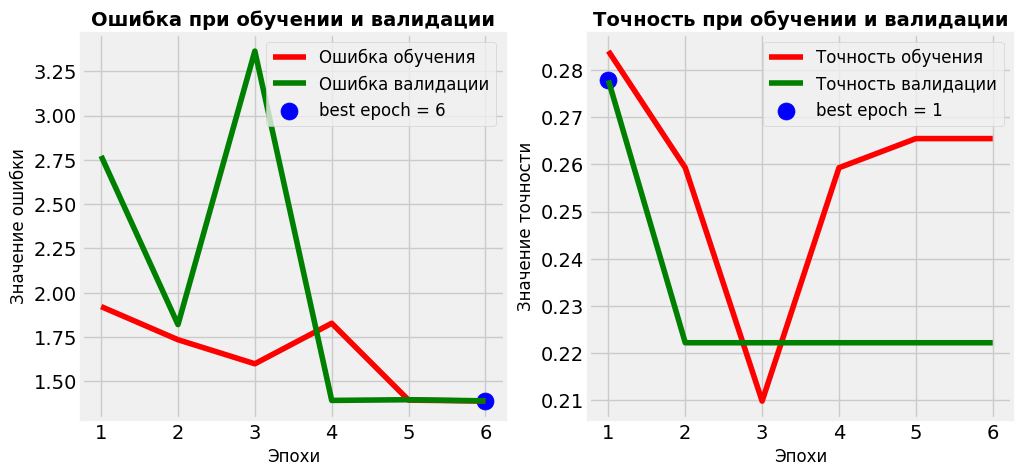

In [23]:
plot_training_curves(history)

In [24]:
y_predicted_prob = model.predict([X_test, test_mask]) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

1/1 [==============================] - 5s 5s/step


In [25]:
generate_preformance_scores(y_tested, y_predicted, y_predicted_prob)

Accuracy Score:		0.2500
Precision_score:	0.0225
Recall_score:		0.1500
F1_score:		0.0391
AUC Score:		0.5442


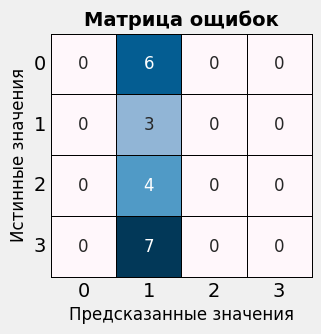

In [26]:
plot_confusion_matrix(y_tested, y_predicted, figsize=(3, 3))

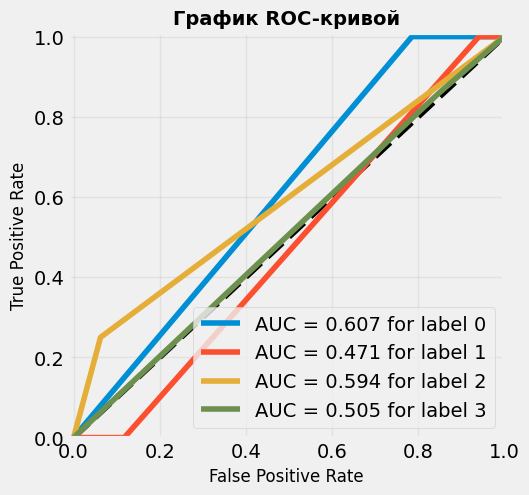

In [27]:
plot_multiclass_roc(y_tested, y_predicted_prob, 4)

# Чтение данных

In [35]:
df = pd.read_csv("/content/poem_ds.csv", sep=";")
df.head()

,author,fragment
0,Цветаева,"Мне нравится, что Вы больны не мной,\nМне нрав..."
1,Цветаева,"Спасибо Вам и сердцем и рукой\nЗа то, что Вы м..."
2,Цветаева,Почему ты плачешь? — Так. —\nПлакать так смешн...
3,Цветаева,"Пышность замков, разгульность охоты,\nИспытань..."
4,Цветаева,"Вот: слышится — а слов не слышу,\nВот: близитс..."


In [36]:
df["fragment"] = df["fragment"].apply(unify_fragment)

In [37]:
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["author"])

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [39]:
# Создаем токенизатор и обучаем его на всех текстах
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["fragment"])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df["fragment"], df["label"], test_size=0.2, random_state = 47)

In [41]:
from keras.utils import to_categorical

In [42]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
# Преобразуем тексты в последовательности целых чисел
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Определяем максимальную длину последовательности
max_length = max([len(x) for x in train_sequences])

# Дополняем последовательности до максимальной длины
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1  # Размер словаря

## LSTM

In [45]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length))
model.add(keras.layers.LSTM(256, return_sequences=True))
model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dense(4, activation='softmax'))

In [46]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 124, 256)          1190400   
                                                                 
 lstm (LSTM)                 (None, 124, 256)          525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2242052 (8.55 MB)
Trainable params: 2242052 (8.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
history = model.fit(train_padded,
                    y_train,
                    batch_size=64,
                    epochs=6,
                    validation_split=0.2)

Epoch 1/6
2/2 [==============================] - 5s 896ms/step - loss: 1.3911 - accuracy: 0.2422 - val_loss: 1.3939 - val_accuracy: 0.2188
Epoch 2/6
2/2 [==============================] - 0s 146ms/step - loss: 1.3896 - accuracy: 0.2422 - val_loss: 1.3987 - val_accuracy: 0.2500
Epoch 3/6
2/2 [==============================] - 0s 146ms/step - loss: 1.3858 - accuracy: 0.2656 - val_loss: 1.3925 - val_accuracy: 0.2500
Epoch 4/6
2/2 [==============================] - 0s 152ms/step - loss: 1.3858 - accuracy: 0.2500 - val_loss: 1.3916 - val_accuracy: 0.2188
Epoch 5/6
2/2 [==============================] - 0s 156ms/step - loss: 1.3857 - accuracy: 0.2812 - val_loss: 1.3871 - val_accuracy: 0.2188
Epoch 6/6
2/2 [==============================] - 0s 143ms/step - loss: 1.3860 - accuracy: 0.2812 - val_loss: 1.3936 - val_accuracy: 0.2188


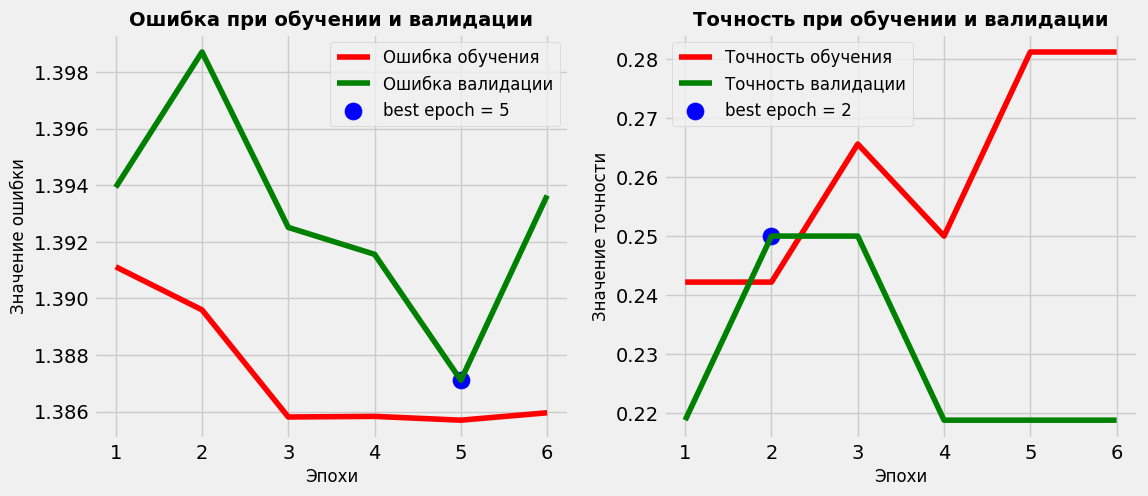

In [48]:
plot_training_curves(history)

In [49]:
y_predicted_prob = model.predict(test_padded)
y_predicted = np.argmax(y_predicted_prob, axis=1)

2/2 [==============================] - 1s 13ms/step


In [57]:
y_tested = np.argmax(y_test, axis=1)

In [59]:
generate_preformance_scores(y_tested, y_predicted, y_predicted_prob)

Accuracy Score:		0.2500
Precision_score:	0.0400
Recall_score:		0.2000
F1_score:		0.0667
AUC Score:		0.4807


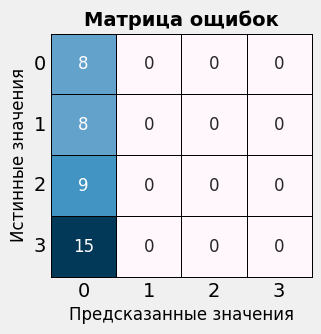

In [60]:
plot_confusion_matrix(y_tested, y_predicted, figsize=(3, 3))

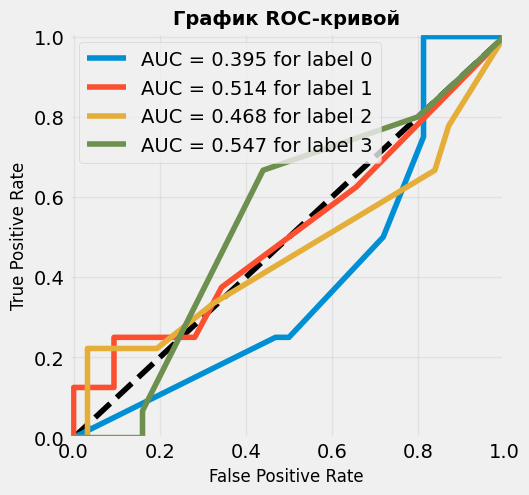

In [61]:
plot_multiclass_roc(y_tested, y_predicted_prob, 4)

## Bi-LSTM

In [62]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

In [63]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 124, 256)          1190400   
                                                                 
 bidirectional (Bidirection  (None, 124, 256)          394240    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1995588 (7.61 MB)
Trainable params: 1995

In [64]:
history = model.fit(train_padded,
                    y_train,
                    batch_size=64,
                    epochs=6,
                    validation_split=0.2)

Epoch 1/6
2/2 [==============================] - 13s 6s/step - loss: 1.3866 - accuracy: 0.2578 - val_loss: 1.3975 - val_accuracy: 0.2188
Epoch 2/6
2/2 [==============================] - 1s 639ms/step - loss: 1.3776 - accuracy: 0.3594 - val_loss: 1.3915 - val_accuracy: 0.2500
Epoch 3/6
2/2 [==============================] - 1s 540ms/step - loss: 1.3633 - accuracy: 0.4688 - val_loss: 1.3913 - val_accuracy: 0.2500
Epoch 4/6
2/2 [==============================] - 0s 282ms/step - loss: 1.3286 - accuracy: 0.4375 - val_loss: 1.3944 - val_accuracy: 0.2500
Epoch 5/6
2/2 [==============================] - 0s 246ms/step - loss: 1.2479 - accuracy: 0.7734 - val_loss: 1.3791 - val_accuracy: 0.3438
Epoch 6/6
2/2 [==============================] - 0s 156ms/step - loss: 1.0591 - accuracy: 0.9297 - val_loss: 1.3156 - val_accuracy: 0.3125


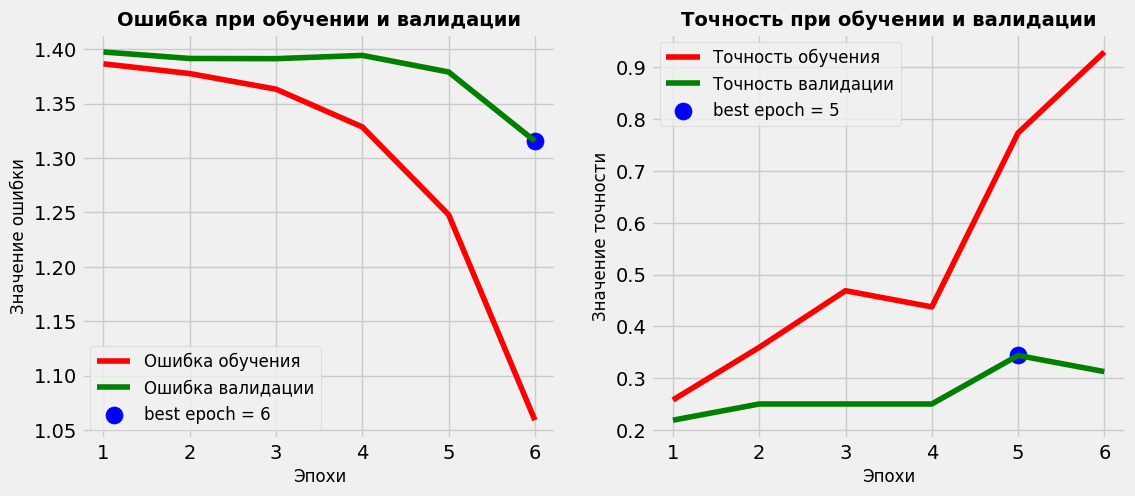

In [65]:
plot_training_curves(history)

In [66]:
y_predicted_prob = model.predict(test_padded)
y_predicted = np.argmax(y_predicted_prob, axis=1)

2/2 [==============================] - 2s 12ms/step


In [67]:
generate_preformance_scores(y_tested, y_predicted, y_predicted_prob)

Accuracy Score:		0.4590
Precision_score:	0.4929
Recall_score:		0.4750
F1_score:		0.4603
AUC Score:		0.6735


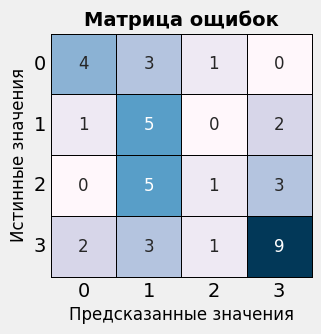

In [68]:
plot_confusion_matrix(y_tested, y_predicted, figsize=(3, 3))

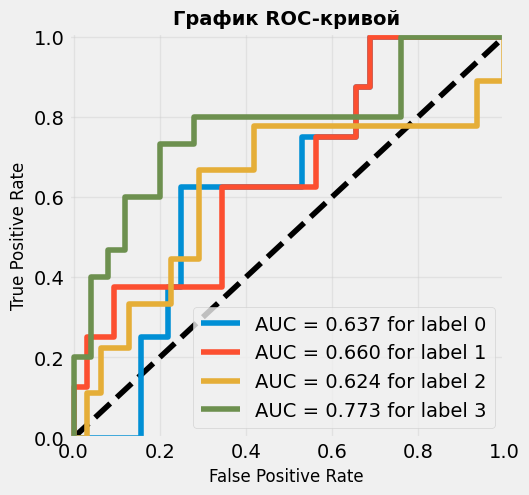

In [69]:
plot_multiclass_roc(y_tested, y_predicted_prob, 4)